# Below is how I approach the Movie project
### 1. Frame the Problem and Look at the Big Picture
1. Define the objective in business terms.
    - There are two objectives namely knowing the projected revenue and customer interests.
2. How will your solution be used?
    - Solution will be used by companies to understand what profits to expect based on various factors.
    - Movie lovers can get recommendation of movies based on movies they've seen.
3. What are the current solutions/workarounds (if any)?
    - Currently no solutions as I'm building from scratch.
4. How should you frame this problem (supervised/unsupervised,online/offline, etc.)?
    - Supervised and online.
5. How should performance be measured?
    - For revenue will use rsme.
    - For recommender system will figure out a performance measure.
6. Is the performance measure aligned with the business objective?
    - Yes.
7. What would be the minimum performance needed to reach the business objective?
    - For revenue a score of 94% is acceptable. 
    - For recommender system will figure out but something similar to revenue score. 
8. What are comparable problems? Can you reuse experience or tools?
    - Assume none exist.
9. Is human expertise available?
    - Assume no.
10. How would you solve the problem manually?
    - For revenue talking to production managers and people in the movie industry.
    - For recommendor asking random people what other movies they love after identifying a base of movies they love.
11. List the assumptions you (or others) have made so far.
    - None identified at this point. 
12. Verify assumptions if possible.
    - None to verify. 

In [1]:
# data exploratory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# first import movies_metadata
movies = pd.read_csv("../../../Data/archive/movies_metadata.csv", low_memory=False)

In [3]:
'''
Here I sample training data to avoid data snooping. Will use random sampling since 
there is no feature that forces strata sampling
'''
from sklearn.model_selection import train_test_split
train_set, test_test = train_test_split(movies, test_size=0.2, random_state=48)
movies = train_set

In [4]:
# to view all of the columns
pd.set_option('display.max_columns', None)

In [5]:
# checking the size and type of data
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36372 entries, 26130 to 15872
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  36372 non-null  object 
 1   belongs_to_collection  3604 non-null   object 
 2   budget                 36372 non-null  object 
 3   genres                 36372 non-null  object 
 4   homepage               6198 non-null   object 
 5   id                     36372 non-null  object 
 6   imdb_id                36356 non-null  object 
 7   original_language      36365 non-null  object 
 8   original_title         36372 non-null  object 
 9   overview               35588 non-null  object 
 10  popularity             36368 non-null  object 
 11  poster_path            36060 non-null  object 
 12  production_companies   36370 non-null  object 
 13  production_countries   36370 non-null  object 
 14  release_date           36300 non-null  object 
 15  rev

# Here are the columns with missing data and those without
## Columns without missing data
    - [adult, budget, genres, id, original_title]
## Columns with missing data
    - [belongs_to_collection, homepage, imdb_id, original_language, overview, popularity, poster_path, production_companies, production_countries, release_date, revenue, runtime, spoken_languages, status, tagline, title, video, vote_average, vote_count]

In [6]:
# here the columns are randomly selected as they're easier to work with. 
# later will devise a method to work with only necessary columns. 
columns_of_interest = ['adult', 'budget', 'original_language', 'original_title', 
                       'overview','popularity','release_date', 'revenue', 'runtime',
                       'status', 'tagline', 'title', 'video',
                       'vote_average', 'vote_count']
movies = movies.loc[:,columns_of_interest]

In [7]:
# this function is used as there as some entries in budget that can't ...
# be converted to numeric type thus this function fills those values with null

def convert_budget(budget):
    try:
        if type(float(budget)) == float:
            return budget
    except:
        return None
movies['budget'] = movies['budget'].apply(convert_budget)

In [8]:
# sets up release_date column for easy conversion
def convert_release_date(date):
    if type(date) == str:
        if len(date) <= 2:
            return None
        # because the rest have length 10
        else:
            return date
    # because the rest are nan
    else:
        return None
movies['release_date'] = movies['release_date'].apply(convert_release_date)

In [9]:
# sets up popularity column for easy conversion
def convert_popularity(popular):
    if type(popular) == str:
        return popular
    # because rest is nan
    else:
        return None
movies['popularity'] = movies['popularity'].apply(convert_popularity)

In [10]:
movies = movies.astype({'adult': bool,
                        'original_title': str, 
                        'budget': float,
                        'overview': str,
                        'popularity': float, 
                        'revenue': float, 
                        'runtime': float,
                        'status': str,
                        'tagline': str, 
                        'title': str,
                        'release_date': 'datetime64[ns]',
                        'video': bool,
                        'vote_average': float, 
                        'vote_count': float
                       })

In [11]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36372 entries, 26130 to 15872
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   adult              36372 non-null  bool          
 1   budget             36370 non-null  float64       
 2   original_language  36365 non-null  object        
 3   original_title     36372 non-null  object        
 4   overview           36372 non-null  object        
 5   popularity         36368 non-null  float64       
 6   release_date       36298 non-null  datetime64[ns]
 7   revenue            36368 non-null  float64       
 8   runtime            36159 non-null  float64       
 9   status             36372 non-null  object        
 10  tagline            36372 non-null  object        
 11  title              36372 non-null  object        
 12  video              36372 non-null  bool          
 13  vote_average       36368 non-null  float64       
 14  vote_co

In [30]:
describe_numeric = movies.describe()
describe_numeric.loc["mean",:]

4250074.938438273

In [14]:
describe_numeric

,budget,popularity,release_date,revenue,runtime,vote_average,vote_count
count,3.637000e+04,36368.000000,36298,3.636800e+04,36159.000000,36368.000000,36368.000000
mean,4.250075e+06,2.909196,1992-05-15 15:29:18.443991296,1.116960e+07,94.019718,5.616770,109.167097
min,0.000000e+00,0.000000,1878-06-14 00:00:00,0.000000e+00,0.000000,0.000000,0.000000
25%,0.000000e+00,0.384170,1978-10-01 00:00:00,0.000000e+00,85.000000,5.000000,3.000000
50%,0.000000e+00,1.127023,2001-08-29 12:00:00,0.000000e+00,95.000000,6.000000,10.000000
75%,0.000000e+00,3.698018,2010-12-22 18:00:00,0.000000e+00,107.000000,6.800000,34.000000
max,3.800000e+08,294.337037,2020-12-16 00:00:00,2.787965e+09,1256.000000,10.000000,14075.000000
std,1.739784e+07,5.416907,NaN,6.391748e+07,38.728873,1.923955,485.009043


C:\Users\Admin\AppData\Local\Temp\ipykernel_7516\616661945.py:2: RuntimeWarning: overflow encountered in power
  arr = np.power(arr, 1000)


<Axes: >

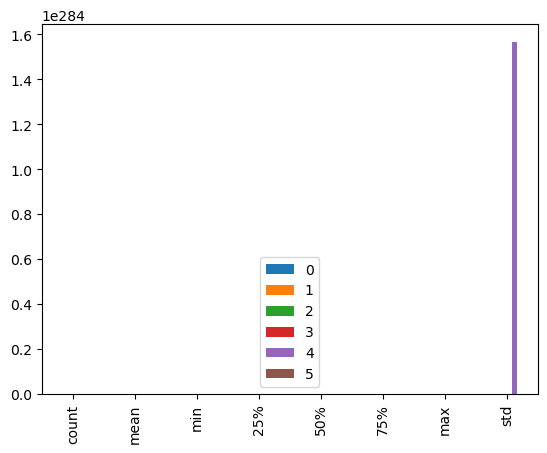

In [15]:
arr = np.array(describe_numeric.drop("release_date", axis=1))
arr = np.power(arr, 1000)
df = pd.DataFrame(arr, describe_numeric.index)
df.plot(kind="bar")

In [16]:
movies.describe(include='object')

,original_language,original_title,overview,status,tagline,title
count,36365,36372,36372,36372,36372,36372
unique,86,34998,35429,7,16238,34231
top,en,Hamlet,nan,Released,nan,Hamlet
freq,25785,8,784,36011,20056,9


In [17]:
movies.head()

,adult,budget,original_language,original_title,overview,popularity,release_date,revenue,runtime,status,tagline,title,video,vote_average,vote_count
26130,True,0.0,en,Beneath the Harvest Sky,A teen drama set during the fall potato harves...,7.558162,2013-09-08,0.0,116.0,Released,nan,Beneath the Harvest Sky,False,6.4,7.0
33971,True,0.0,es,La residencia,Lilli Palmer owns and runs a school for waywar...,1.125099,1969-01-01,0.0,104.0,Released,The Suspense is Sheer Torture in ...,The House That Screamed,False,7.0,13.0
3586,True,15000000.0,en,Firestarter,"As youths, Andy McGee (David Keith) and his fu...",7.048087,1984-05-11,17080167.0,114.0,Released,Will she have the power... to survive?,Firestarter,False,5.9,174.0
4481,True,0.0,en,The January Man,Nick and Frank Starkey were both policemen. A ...,3.064362,1989-01-13,0.0,97.0,Released,Catching a serial killer takes a seriously twi...,The January Man,False,5.1,41.0
15398,True,0.0,en,Saving God,Ex Con Armstrong Cane (Ving Rhames) returns to...,0.965066,2008-10-14,0.0,101.0,Released,nan,Saving God,False,6.0,2.0


<Axes: xlabel='budget', ylabel='revenue'>

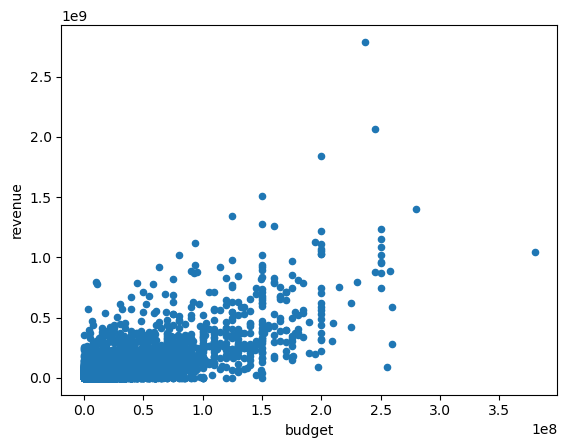

In [18]:
movies.plot(kind="scatter", x="budget", y="revenue")

<Axes: xlabel='budget', ylabel='revenue'>

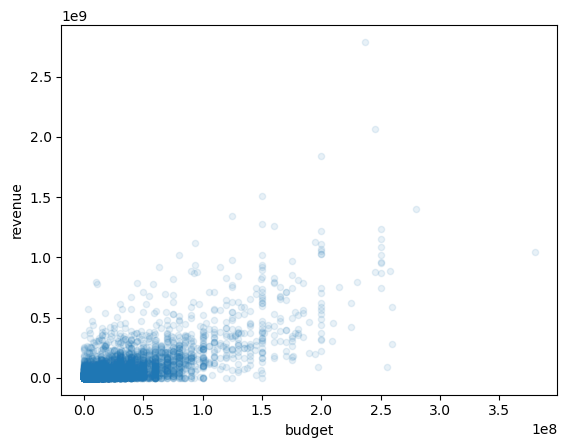

In [19]:
movies.plot(kind="scatter", x="budget", y="revenue", alpha=0.1)

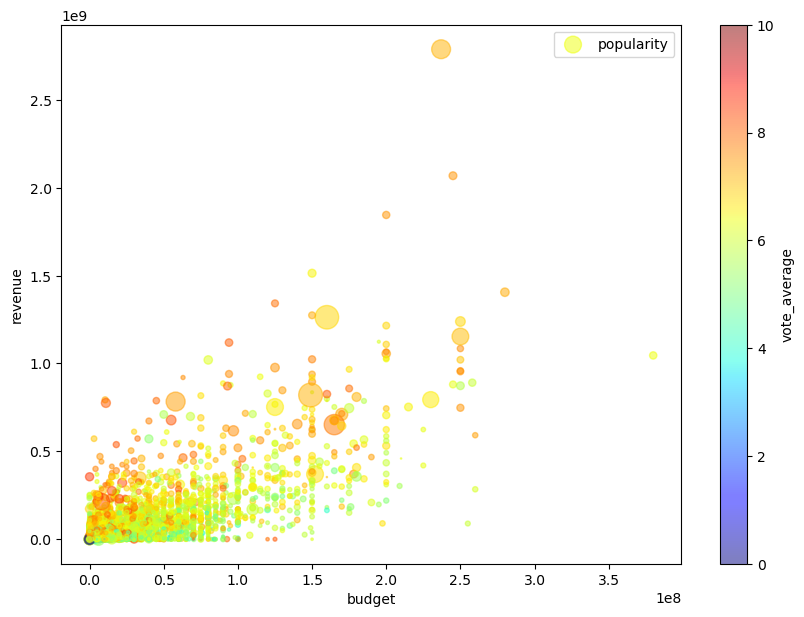

In [20]:
movies.plot(kind="scatter", x="budget", y="revenue", alpha=0.5,
            s="popularity", label="popularity", figsize=(10,7),
            c="vote_average", cmap=plt.get_cmap("jet"), colorbar=True,
           )
plt.legend()

array([[<Axes: xlabel='budget', ylabel='budget'>,
        <Axes: xlabel='popularity', ylabel='budget'>,
        <Axes: xlabel='revenue', ylabel='budget'>,
        <Axes: xlabel='runtime', ylabel='budget'>,
        <Axes: xlabel='vote_average', ylabel='budget'>,
        <Axes: xlabel='vote_count', ylabel='budget'>],
       [<Axes: xlabel='budget', ylabel='popularity'>,
        <Axes: xlabel='popularity', ylabel='popularity'>,
        <Axes: xlabel='revenue', ylabel='popularity'>,
        <Axes: xlabel='runtime', ylabel='popularity'>,
        <Axes: xlabel='vote_average', ylabel='popularity'>,
        <Axes: xlabel='vote_count', ylabel='popularity'>],
       [<Axes: xlabel='budget', ylabel='revenue'>,
        <Axes: xlabel='popularity', ylabel='revenue'>,
        <Axes: xlabel='revenue', ylabel='revenue'>,
        <Axes: xlabel='runtime', ylabel='revenue'>,
        <Axes: xlabel='vote_average', ylabel='revenue'>,
        <Axes: xlabel='vote_count', ylabel='revenue'>],
       [<Axes: xlab

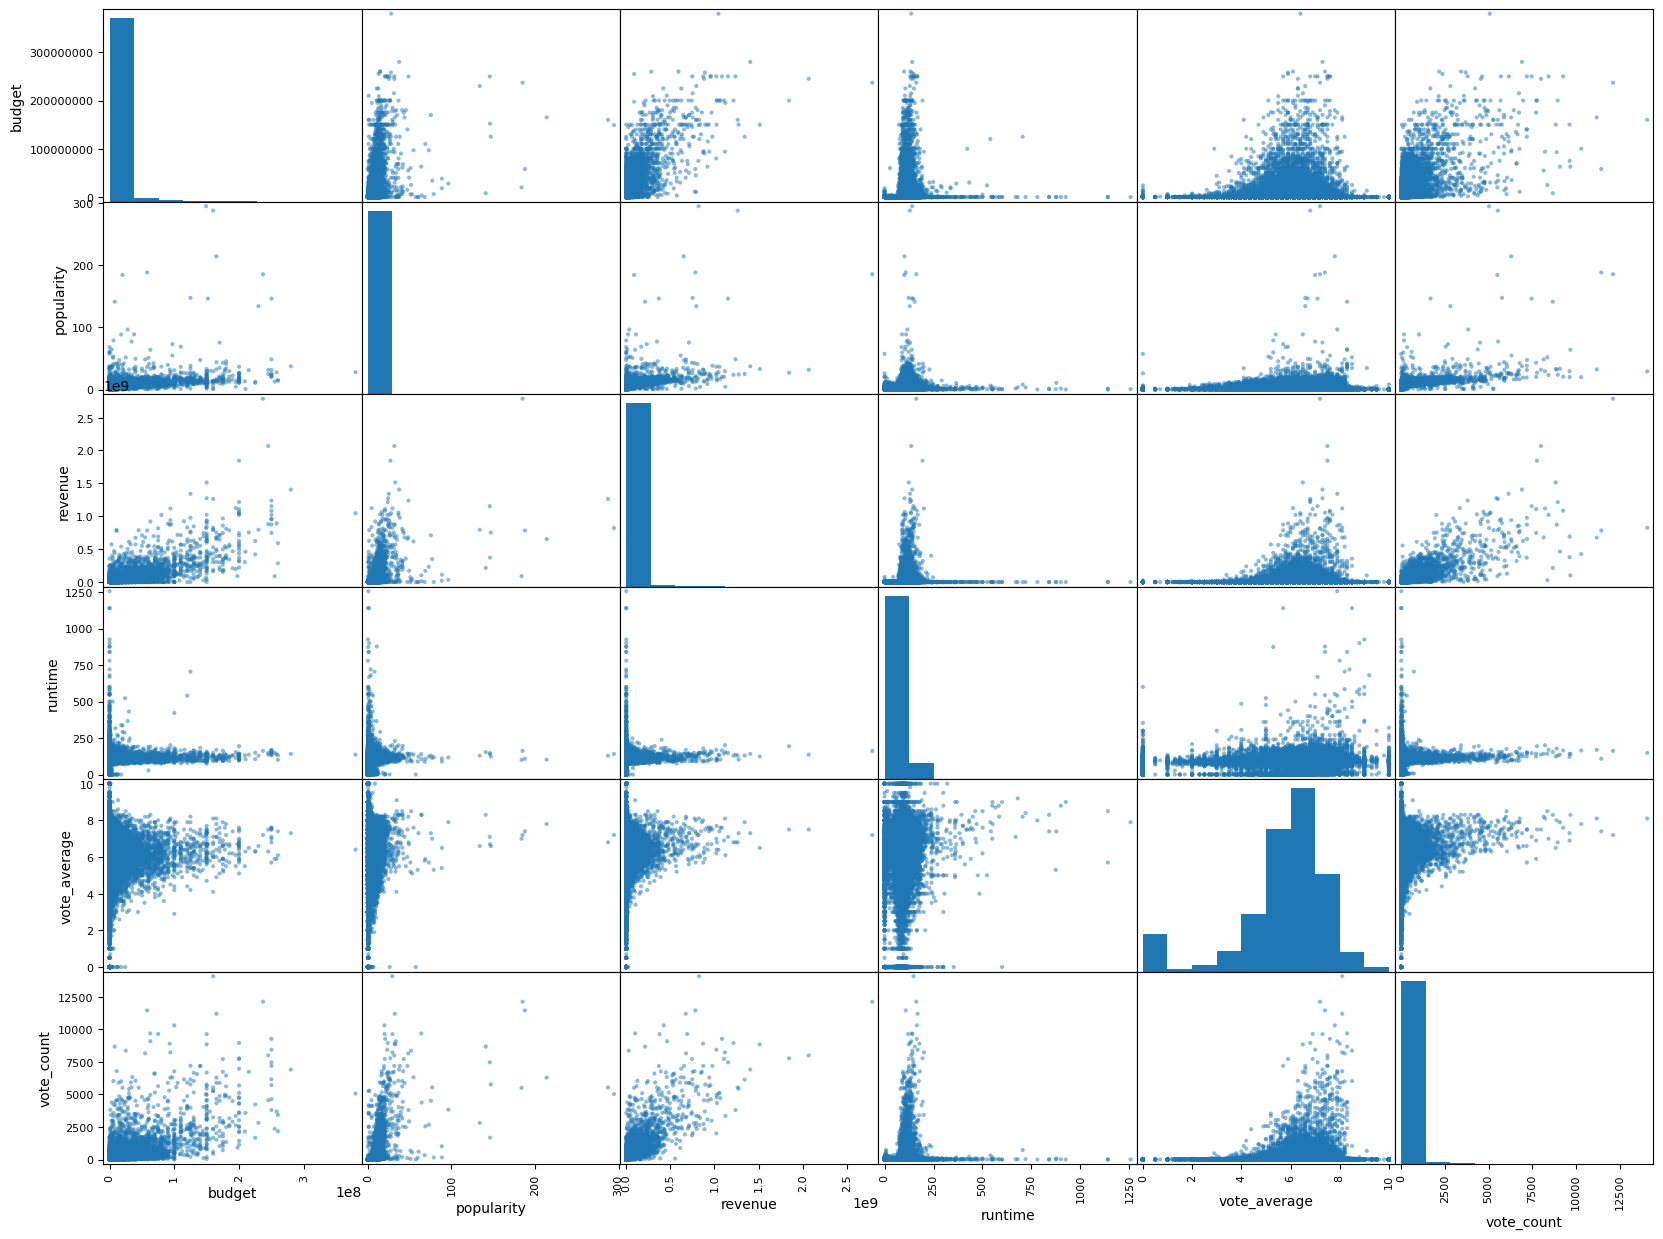

In [21]:
from pandas.plotting import scatter_matrix

num_attributes = ["budget", "popularity", "release_date", "revenue", "runtime", "vote_average", "vote_count"]
movies_num = movies.loc[:, num_attributes]
scatter_matrix(movies_num, figsize=(20,15))